# Interactive Real-Time Portfolio Optimization with Machine Learning

This interactive notebook lets you choose a custom list of tickers (stocks, ETFs, or crypto supported by `yfinance`) **at runtime** and then automatically:

1. Downloads historical data for your selected tickers
2. Builds features and trains a machine-learning model to predict next-day returns
3. Optimizes portfolio weights to maximize the Sharpe ratio
4. Back-tests the ML-optimized portfolio versus an equal-weight benchmark

> **How to use**: Run the first three cells to load libraries and choose tickers. After you press the **Set Tickers** button, simply run the remaining cells top-to-bottom.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import scipy.optimize as sco
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings, sys
warnings.filterwarnings('ignore')

print('Libraries imported! Python', sys.version)

Libraries imported! Python 3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]


In [2]:
# -----------------------------------------
# INTERACTIVE TICKER SELECTION
# -----------------------------------------

# Default tickers
default_tickers = 'AAPL, MSFT, GOOGL, AMZN, TSLA'

text_box = widgets.Text(
    value=default_tickers,
    placeholder='e.g. AAPL,MSFT,GOOGL',
    description='Tickers:',
    disabled=False,
    layout=widgets.Layout(width='70%')
)
set_button = widgets.Button(description='Set Tickers', button_style='success')
output = widgets.Output()

def on_button_clicked(b):
    global TICKERS
    tickers_raw = text_box.value
    TICKERS = [t.strip().upper() for t in tickers_raw.split(',') if t.strip()]
    with output:
        clear_output()
        print('Ticker list set to:', TICKERS)

set_button.on_click(on_button_clicked)

display(widgets.HBox([text_box, set_button]))
display(output)

Output()

In [8]:
# -----------------------------------------
# USER CONFIGURATION
# -----------------------------------------
try:
    TICKERS
except NameError:
    raise RuntimeError('Run the ticker selection cell above and press Set Tickers before proceeding!')

START_DATE = (datetime.today() - timedelta(days=365*3)).strftime('%Y-%m-%d')  # 3 years back
END_DATE = datetime.today().strftime('%Y-%m-%d')
RISK_FREE_RATE = 0.02  # 2% annual risk-free rate
TRAIN_SIZE = 0.8

print(f"Running analysis for: {TICKERS}")
print(f"Date range: {START_DATE} to {END_DATE}")

Running analysis for: ['NVDA', 'MSFT', 'AMZN']
Date range: 2022-08-16 to 2025-08-15


In [9]:
def fetch_price_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, progress=False)
    if len(tickers) == 1:
        if 'Adj Close' in data.columns:
            return data[['Adj Close']].rename(columns={'Adj Close': tickers[0]})
        return data[['Close']].rename(columns={'Close': tickers[0]})
    if isinstance(data.columns, pd.MultiIndex):
        if 'Adj Close' in data.columns.get_level_values(0):
            return data['Adj Close']
        return data['Close']
    return data

price_df = fetch_price_data(TICKERS, START_DATE, END_DATE).ffill().dropna()
print('Fetched price data:', price_df.shape)
price_df.tail()

Fetched price data: (752, 3)


Ticker,AMZN,MSFT,NVDA
Date,,,
2025-08-08,222.690002,522.039978,182.699997
2025-08-11,221.300003,521.770020,182.059998
2025-08-12,221.470001,529.239990,183.160004
2025-08-13,224.559998,520.580017,181.589996
2025-08-14,230.979996,522.479980,182.020004


In [10]:
# Calculate returns and features
returns = price_df.pct_change().dropna()
feature_df = pd.DataFrame(index=returns.index)

lag_days = [1,2,3,5]
for lag in lag_days:
    for t in TICKERS:
        feature_df[f'{t}_lag{lag}'] = returns[t].shift(lag)

window_sizes = [5,10,21]
for win in window_sizes:
    for t in TICKERS:
        feature_df[f'{t}_ma{win}'] = returns[t].rolling(win).mean()
        feature_df[f'{t}_vol{win}'] = returns[t].rolling(win).std()

feature_df = feature_df.dropna()
target_df = returns[TICKERS].shift(-1).loc[feature_df.index]
feature_df = feature_df.loc[target_df.index]

split = int(len(feature_df)*TRAIN_SIZE)
X_train, X_test = feature_df.iloc[:split], feature_df.iloc[split:]
y_train, y_test = target_df.iloc[:split], target_df.iloc[split:]

model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print('Model trained!')

# Predict expected returns
predicted = model.predict(feature_df.iloc[-1:])[0]
exp_returns = pd.Series(predicted, index=TICKERS)
print('Predicted next-day returns (%):')
print((exp_returns*100).round(3))

Model trained!
Predicted next-day returns (%):
NVDA    0.969
MSFT    0.443
AMZN    0.594
dtype: float64


In [11]:
# Portfolio optimization
annual_returns = exp_returns * 252
cov = returns[TICKERS].cov() * 252

num_assets = len(TICKERS)
init_w = np.repeat(1/num_assets, num_assets)

def neg_sharpe(w, mu, cov, rf):
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    return -(ret - rf) / vol

cons = ({'type':'eq', 'fun': lambda w: np.sum(w)-1})
bounds = tuple((0,1) for _ in range(num_assets))

opt = sco.minimize(neg_sharpe, init_w, args=(annual_returns, cov, RISK_FREE_RATE),
                   method='SLSQP', bounds=bounds, constraints=cons)
weights = pd.Series(opt.x if opt.success else init_w, index=TICKERS)
print('Optimized Weights:')
print(weights.apply(lambda x: f"{x:.4f} ({x*100:.2f}%)"))

Optimized Weights:
NVDA    0.3255 (32.55%)
MSFT    0.2949 (29.49%)
AMZN    0.3796 (37.96%)
dtype: object


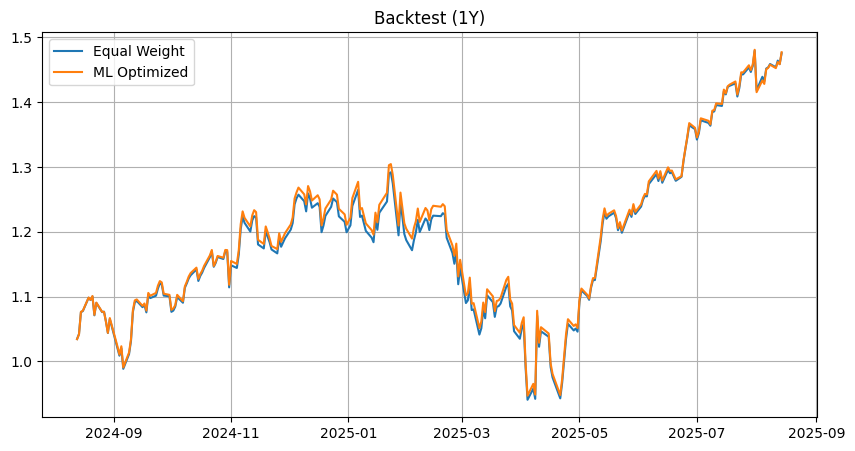

In [12]:
# Backtest vs equal weight on last year
test_returns = returns[TICKERS].iloc[-252:]
num_assets = len(TICKERS)

cum_equal = (1 + (test_returns * (1/num_assets)).sum(axis=1)).cumprod()
cum_ml = (1 + (test_returns * weights).sum(axis=1)).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cum_equal, label='Equal Weight')
plt.plot(cum_ml, label='ML Optimized')
plt.title('Backtest (1Y)')
plt.legend(); plt.grid(True); plt.show()

Feel free to re-run the ticker-selection cell to try different portfolios.
• **Adjust tickers** to any symbols available on Yahoo Finance (including crypto tickers like `BTC-USD`).
• **Experiment** with model parameters, features, or optimization constraints in subsequent cells.